In [35]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/')

import torch
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

from models.simple_LSTM import *
from models.train_model import train, k_fold
from models.early_stopping import EarlyStopping
from data.LSTM_dataset import LSTMDataset
from models.metrics import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
import matplotlib

font = {'size' : 18}

matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = (10, 5)


In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [123]:
torch.manual_seed(0)
np.random.seed(0)

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x : x.squeeze()),
        ])

features_selection = ['max_energies', 'N1', 'N3']
dataset = LSTMDataset('../data/dataset_pickle', '../data/MHD_labels/', features_selection, transform, max_length=4096)


data processing: 100%|██████████| 94/94 [00:09<00:00,  9.89it/s]


In [124]:
size = int(len(dataset) * 0.9)

train_set, test_set = torch.utils.data.random_split(dataset, [size, len(dataset)-size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128)
val_loader = torch.utils.data.DataLoader(test_set, batch_size=128)
print(f'train size : {len(train_set)}, val size : {len(test_set)}')

train size : 84, val size : 10


In [125]:
def compute_pos_weight(data):
    size = 0
    nb_pos = 0
    for item in data:
        labels = item[1]
        size += len(labels.flatten())
        nb_pos +=(labels == 1).sum()
    return size / nb_pos

compute_pos_weight(train_loader)

tensor(8.4755)

In [137]:
input_size = dataset[0][0].shape[1]
print(f'input_size={input_size}')
hidden_size = 8
num_layers = 2
lr = 0.001
weight_decay = 1e-06
l1_sigma = 0 

pos_weight = compute_pos_weight(train_loader) # size / # pos

model = SimpleLSTM(input_size, hidden_size, num_layers, dropout_rate=0.5)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

patience=5
delta=1e-5
model_path = '../models/lstm.pt'
early_stopping = EarlyStopping(model_path, patience, delta)

print(model)    
print(optimizer)
print(criterion)
print(f'l1_sigma={l1_sigma}')
print(early_stopping)

input_size=3
The model has 1,001 trainable parameters
SimpleLSTM(
  (lstm): LSTM(3, 8, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Sequential(
    (0): Linear(in_features=8, out_features=1, bias=True)
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 1e-06
)
BCEWithLogitsLoss()
l1_sigma=0
EarlyStopping(
    patience : 5
    delta : 1e-05
)


In [138]:
def create_output(logits, threshold=0.8):
    output = torch.zeros(logits.shape)
    for idx, logit in enumerate(logits):
        if (logit < threshold).all():
            continue

        output[idx] = (logit > threshold) 
    return output


100%|██████████| 500/500 [01:13<00:00,  6.83it/s, score=-.437, train_loss=0.689]


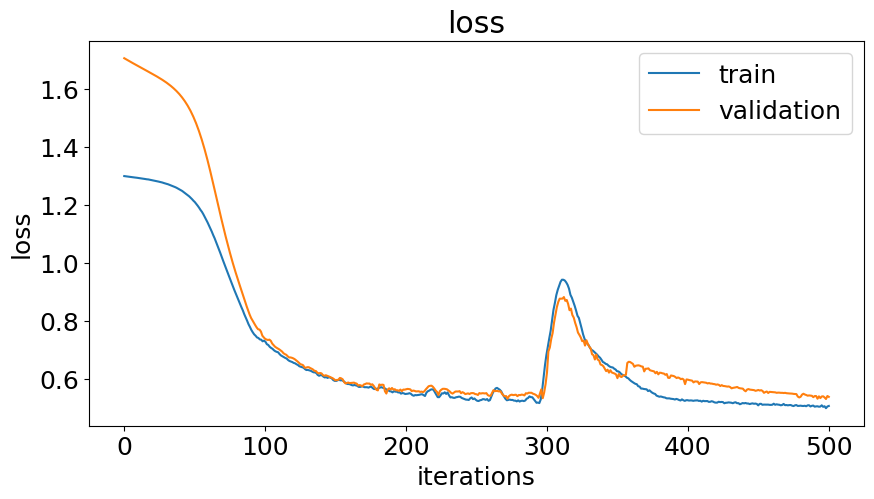

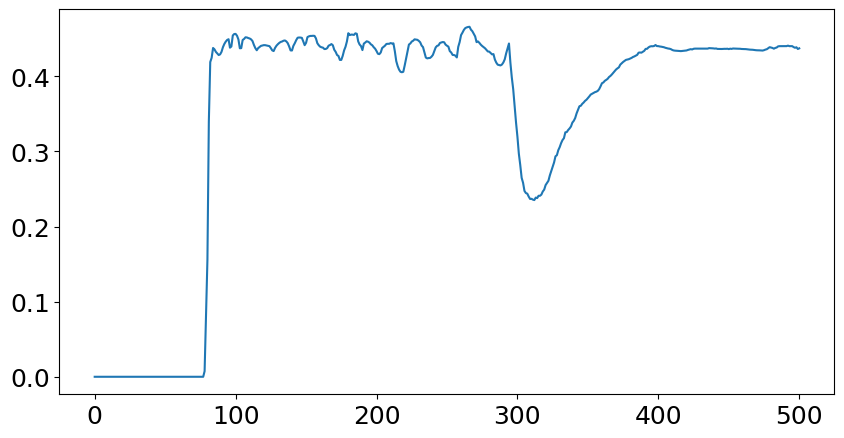

In [140]:
def comptue_score(logits, labels):
      logits = torch.sigmoid(logits).detach()
      preds = create_output(logits.unsqueeze(0)).to(device)
      return -compute_kappa_score(preds, labels)

train(model, 
      train_loader, 
      val_loader, 
      optimizer, 
      criterion, 
      device, 
      compute_score=comptue_score,
      n_epochs=500,
      l1_sigma=l1_sigma,
      # early_stopping=early_stopping)
      early_stopping=None)

kappa=tensor([0.4883])


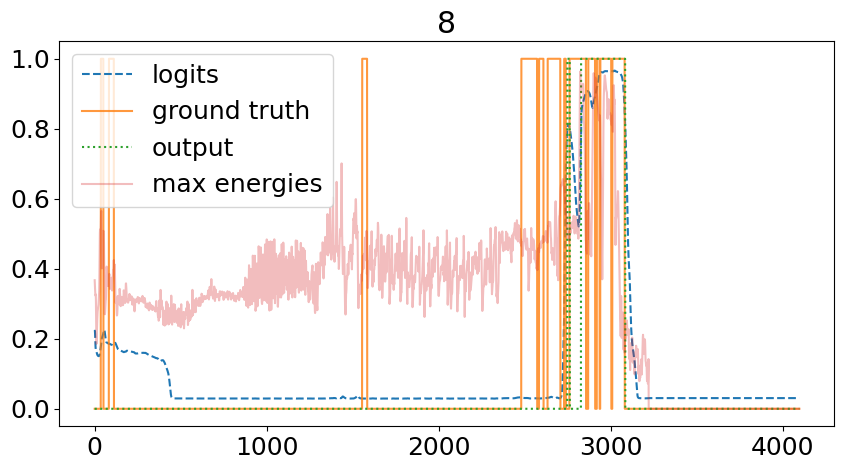

kappa=tensor([0.4883])


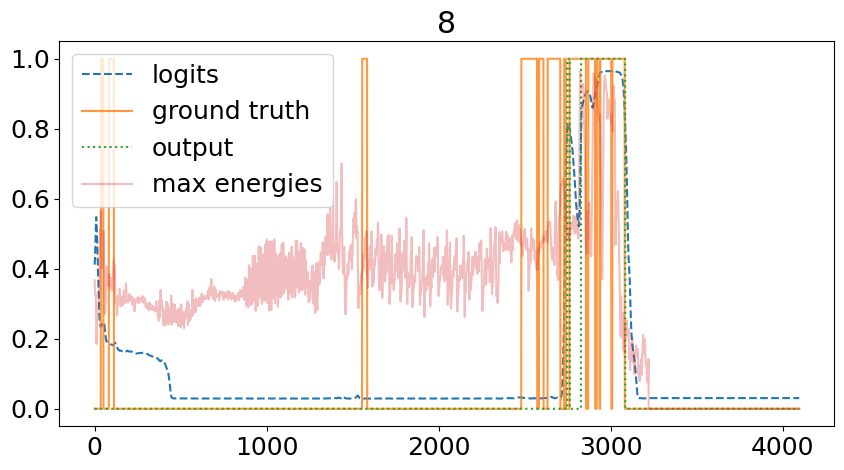

kappa=tensor([0.7489])


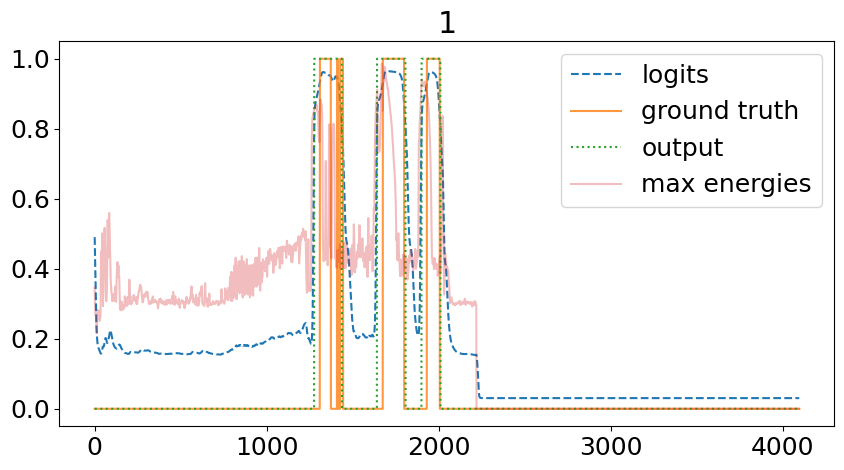

kappa=tensor([0.9459])


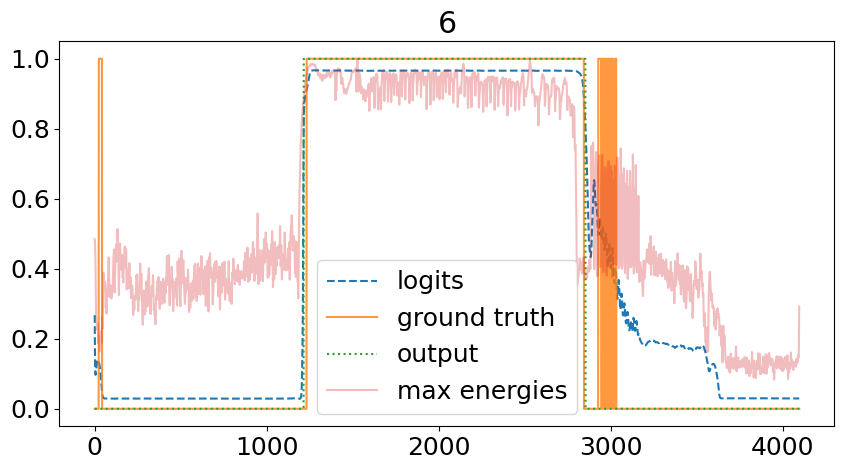

kappa=tensor([0.5244])


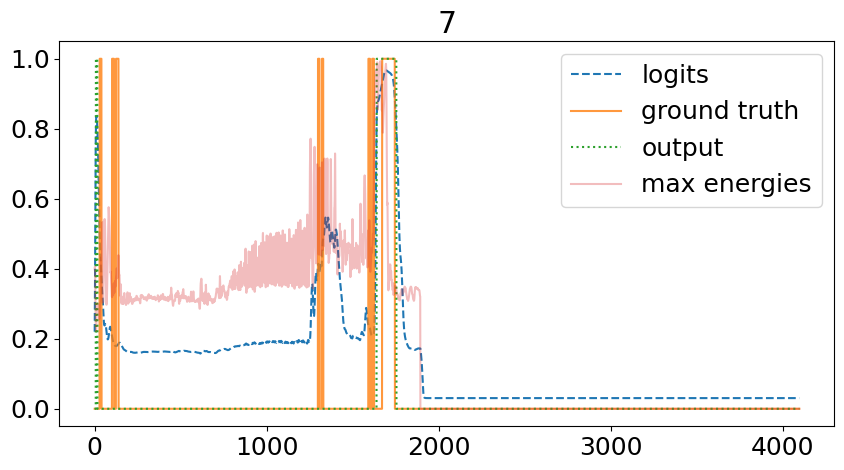

kappa=tensor([0.5223])


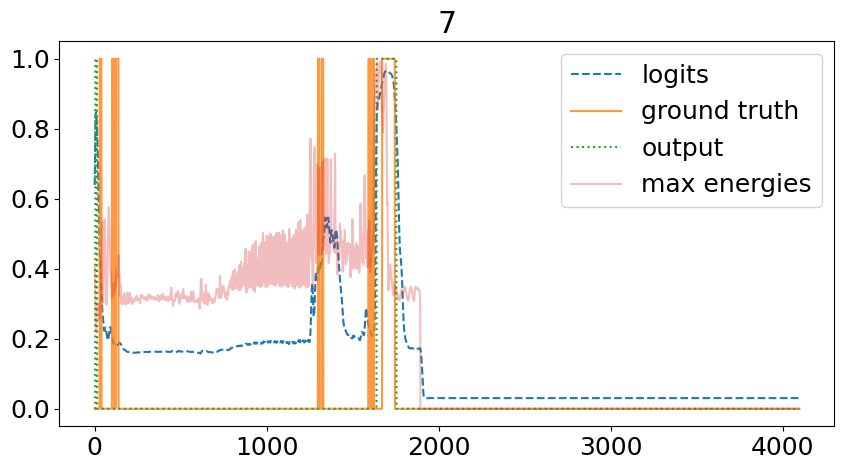

0.717141


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from models.metrics import *

def create_output(logits, threshold=0.8):
    output = torch.zeros(logits.shape)
    for idx, logit in enumerate(logits):
        if (logit < threshold).all():
            continue

        output[idx] = (logit > threshold) 
    return output

model.eval()
with torch.no_grad():
    for idx in np.random.choice(len(test_set), 6): 
        testing_data = test_set[idx]
        logits = torch.sigmoid(model(testing_data[0].to(device))).detach().cpu()
        preds = create_output(logits.unsqueeze(0))
        print(f'kappa={compute_kappa_score(preds == 1, testing_data[1].unsqueeze(0))}')
        plt.title(idx)
        plt.plot(logits.numpy(), label='logits', linestyle='--' )
        plt.plot(testing_data[1], label='ground truth', alpha=0.8)
        plt.plot(preds.squeeze(), label='output', linestyle=':')
        plt.plot(testing_data[0][:,0], label='max energies', alpha=0.3)
        plt.legend()
        plt.show()

    kappa = []

    for x_batch, y_batch in val_loader :
        x_batch = x_batch.to(device)
        
        logits = torch.sigmoid(model(x_batch)).detach().cpu()
        preds = create_output(logits)

        kappa += compute_kappa_score(preds, y_batch)

    print(np.mean(kappa))

# Grid Search

In [141]:
import json
from tqdm import tqdm

k = 4
n_epochs = 200

search_res = []

best_hyper = None

hyperparams = []

                    
for lr in [1e-3, 1e-4]:
    for dropout_rate in [0, 0.2, 0.5]:
        for weight_decay in [0, 1e-6]:
            for l1_sigma in [0, 1e-6] :
                hyperparams.append({'hidden_size' : 8,
                                    'num_layers': 1,
                                    'dropout_rate':dropout_rate,
                                    'lr' : lr,
                                    'weight_decay' : weight_decay,
                                    'l1_sigma' : l1_sigma})

for hidden_size in [4,2]:
        for lr in [1e-3, 1e-4]:
            for dropout_rate in [0, 0.2, 0.5]:
                for weight_decay in [0, 1e-6]:
                    for l1_sigma in [0, 1e-6] :
                        hyperparams.append({'hidden_size' : hidden_size,
                                            'num_layers': 2,
                                            'dropout_rate':dropout_rate,
                                            'lr' : lr,
                                            'weight_decay' : weight_decay,
                                            'l1_sigma' : l1_sigma})
                        
for hidden_size in [4,2]:
    for lr in [1e-3, 1e-4]:
            for weight_decay in [0, 1e-6]:
                for l1_sigma in [0, 1e-6] :
                    hyperparams.append({'hidden_size' : hidden_size,
                                        'num_layers': 1,
                                        'dropout_rate':0,
                                        'lr' : lr,
                                        'weight_decay' : weight_decay,
                                        'l1_sigma' : l1_sigma})


with tqdm(hyperparams) as pbar :    
    for hyperparam in pbar:
        hidden_size = hyperparam['hidden_size']
        num_layers = hyperparam['num_layers']
        lr = hyperparam['lr']
        weight_decay = hyperparam['weight_decay']
        l1_sigma = hyperparam['l1_sigma']
        dropout_rate = hyperparam['dropout_rate']

        model = SimpleLSTM(input_size, hidden_size, num_layers, dropout_rate=dropout_rate)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

        metrics = k_fold(dataset, model, criterion, device, lr, weight_decay,
            k, n_epochs, l1_sigma, batch_size=128, patience=None, disable_pbar=True)

        pbar.set_postfix(hidden_size=hidden_size, num_layers=num_layers, lr=lr, weight_decay=weight_decay,
                         l1_sigma=l1_sigma, dropout_rate=dropout_rate, kappa=metrics["kappa"], best_kappa =  best_hyper['metrics']['kappa'] if best_hyper is not None else 0)
        
        search_res.append({'hidden_size' : hidden_size,
                'num_layers': num_layers,
                'lr' : lr,
                'dropout_rate' : dropout_rate,
                'weight_decay' : weight_decay,
                'l1_sigma' : l1_sigma,
                'metrics': metrics})

        if best_hyper is None or best_hyper['metrics']['kappa'] < metrics['kappa']:
            best_hyper = search_res[-1]

        with open('grid_search.json', 'w', encoding='utf-8') as f:
            json.dump(search_res, f, indent=4)

        del model
        del optimizer
        del criterion

print(best_hyper)

 23%|██▎       | 28/120 [51:34<2:45:20, 107.84s/it, best_kappa=0.116, dropout_rate=0, hidden_size=4, kappa=0.0379, l1_sigma=1e-6, lr=0.001, num_layers=1, weight_decay=1e-6]  c:\Users\Chau\miniconda3\envs\ml_project2\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
 27%|██▋       | 32/120 [58:49<2:39:45, 108.93s/it, best_kappa=0.116, dropout_rate=0.2, hidden_size=4, kappa=0.0853, l1_sigma=1e-6, lr=0.001, num_layers=1, weight_decay=1e-6]c:\Users\Chau\miniconda3\envs\ml_project2\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
 56%|█